# Nutria
In this Notebook we'll consider the population growth of the Nutria species. The data has been taken from .. . We'll begin importing the data and visualizing it.

0.18.0


<AxesSubplot:title={'center':'Nutria population'}>

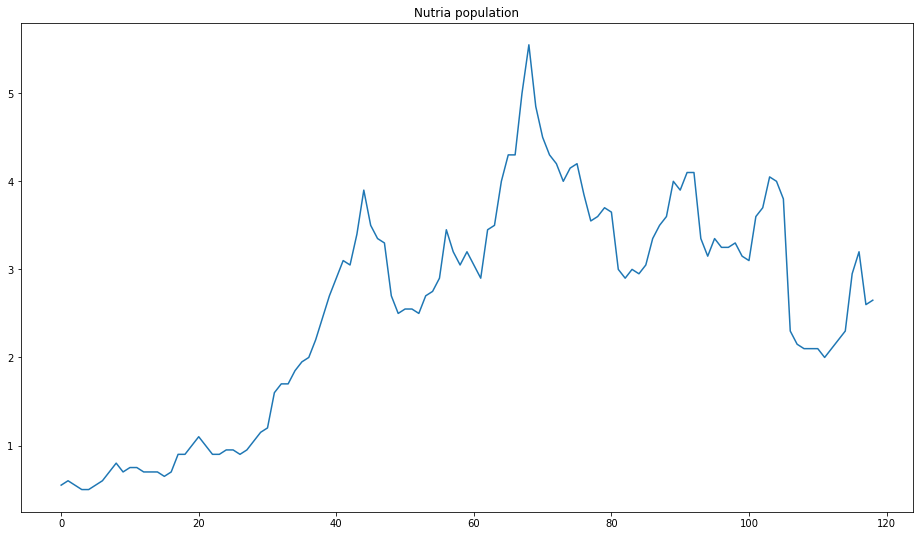

In [1]:
import pandas as pd
from pyfilter import __version__

print(__version__)

data = pd.read_csv("nutria.txt", sep='\t').iloc[:, 0].rename("nutria")

data.plot(figsize=(16, 9), title="Nutria population")

Next, we'll specify the model to use for inference. We'll use the flexible Allee model, found in .. . However, instead of considering the actual population, we'll use the logarithm.

In [2]:
from pyfilter.timeseries import LinearGaussianObservations, AffineProcess
from torch.distributions import Normal, Gamma, TransformedDistribution, AffineTransform, PowerTransform
import torch
from pyfilter.distributions import Prior, DistributionWrapper


def f(x, a, b, c, d):
    exped = x.values.exp()
    return x.values + a + b * exped + c * exped ** 2


def g(x, a, b, c, d):
    return d.sqrt()

def build_invgamma(concentration, rate, power, **kwargs):
    return TransformedDistribution(Gamma(alpha, rate, **kwargs), PowerTransform(power))


alpha = data.shape[0] / 2.0
beta = 2.0 * (alpha - 1.0) / 10.0

invgamma_prior = Prior(
    build_invgamma,
    concentration=alpha, 
    rate=beta,
    power=-1.0
) 

norm_prior = Prior(Normal, loc=0.0, scale=1.0)
h_priors = norm_prior, norm_prior, norm_prior, invgamma_prior

dist = DistributionWrapper(Normal, loc=0.0, scale=1.0)
hidden = AffineProcess((f, g), h_priors, dist, dist)

model = LinearGaussianObservations(hidden, 1.0, invgamma_prior)

Next, we'll use PMMH together with APF to perform inference on the logged dataset.

In [19]:
from pyfilter.inference.batch.mcmc import PMMH, proposals as p
from pyfilter.filters.particle import APF
import numpy as np


logged_data = torch.from_numpy(data.values).float().log().cuda()

filt = APF(model, 500)
alg = PMMH(filt, 1500).cuda()

state = alg.fit(logged_data)

PMMH: 100%|████████████████████████████████████████████████████████████████████████| 1500/1500 [18:12<00:00,  1.37it/s]


Next, let's visualize the filtered means of the state.

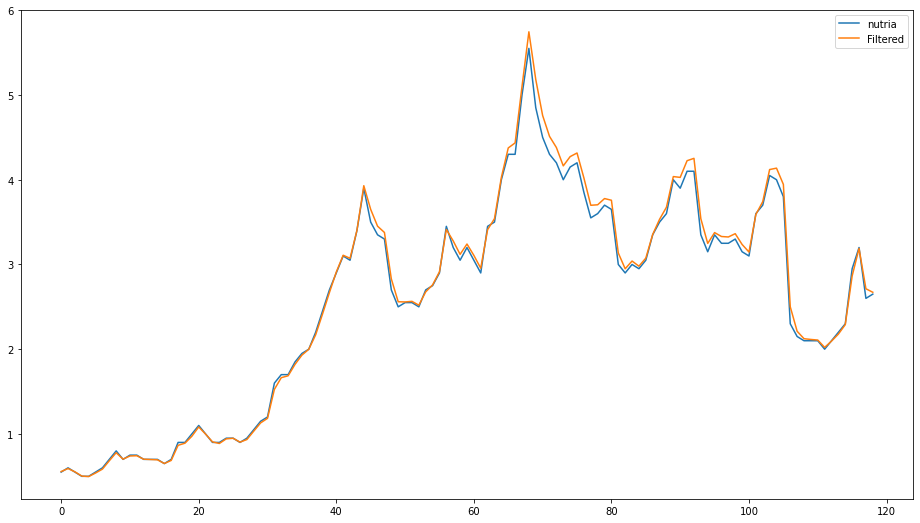

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 9))

data.plot(ax=ax)

ax.plot(state.filter_state.filter_means.mean(dim=1)[1:].exp().cpu().numpy(), label='Filtered')

ax.legend()

Next, let's visualize the posterior distributions of the parameters.

H:\anaconda3\lib\site-packages\arviz\stats\density_utils.py:250: RuntimeWarning: divide by zero encountered in double_scalars
  t_j = np.power((c1 * (c2 / (N * f))), (2.0 / (3.0 + 2.0 * j)))
H:\anaconda3\lib\site-packages\arviz\stats\density_utils.py:254: RuntimeWarning: divide by zero encountered in double_scalars
  out = t - (2 * N * np.pi ** 0.5 * f) ** (-0.4)
H:\anaconda3\lib\site-packages\arviz\stats\density_utils.py:278: RuntimeWarning: invalid value encountered in double_scalars
  bw = (_bw_silverman(x) / np.ptp(x)) ** 2
H:\anaconda3\lib\site-packages\arviz\stats\density_utils.py:768: RuntimeWarning: invalid value encountered in true_divide
  f = grid_counts / bin_width / len(x)


ValueError: cannot convert float NaN to integer

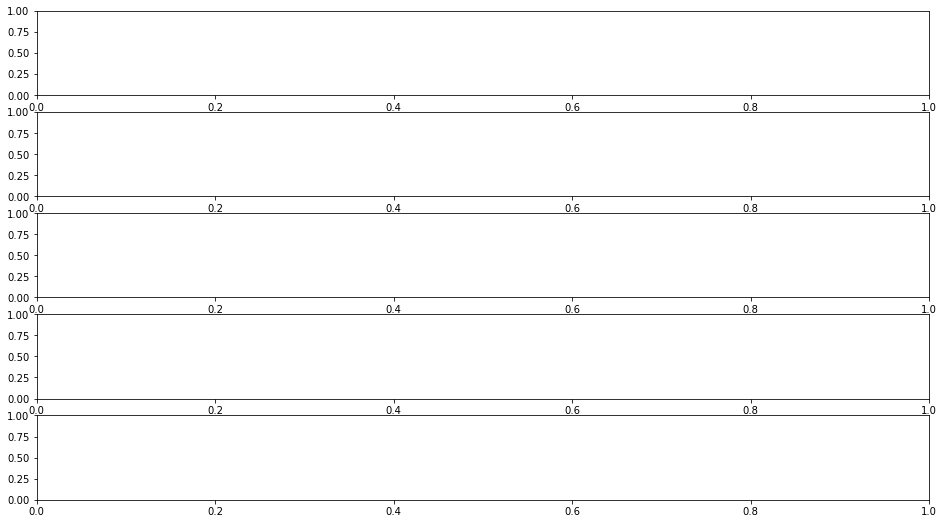

In [21]:
from pyfilter.utils import normalize
import pandas as pd
from arviz import plot_posterior

fig, ax = plt.subplots(5, figsize=(16, 9))
colors = ["lightblue", "orange"]

names = "a, b, c, d, \sigma".split(", ")

params = state.samples.values()[1000:].reshape(-1, 5).cpu().numpy()

for i in range(params.shape[-1]):
     plot_posterior(params[:, i], ax=ax[i], point_estimate=None, hdi_prob="hide")
     ax[i].set_title(f"${names[i]}$")

plt.tight_layout()